In [56]:
running_on_kaggle = True

if running_on_kaggle:
    # Kaggle does not automatically have this
    !pip install torch_geometric -q

In [57]:
import os
import sys
from tqdm import tqdm
from datetime import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch

In [58]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

if running_on_kaggle:
    train_file = np.load("/kaggle/input/cse-251-b-2025/train.npz")
    test_file = np.load("/kaggle/input/cse-251-b-2025/test_input.npz")
else:
    train_file = np.load("./cse-251-b-2025/train.npz")
    test_file = np.load("./cse-251-b-2025/test_input.npz")

train_data = train_file['data']
test_data = test_file['data']

print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

In [59]:
# Run visualizations?
run_visualizations: bool = False

# From data loading notebook
def plot_one_training_scene(idx: int = 0):
    # Plot trajectories from one training scene (static plot)
    data_matrix = train_data[idx]

    plt.figure(figsize=(8, 8))
    for agent in range(data_matrix.shape[idx]):
        xs = data_matrix[agent, :, 0]
        ys = data_matrix[agent, :, 1]
        # Remove zeros (padding)
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.7)
    plt.title("Trajectories from one training scene")
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")
    plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

if run_visualizations:
    plot_one_training_scene(0)
    make_gif(train_data[0], 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [60]:
# Run constant velocity model (Kaggle score of ~50)?
run_constant_velocity_model: bool = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [61]:
# MLP model with residual blocks: ineffective for TimeSeries data
class BasicMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # Lazy layers infer the input size instead of having to explicitly pass it in
        # Backbone: linear -> BatchNorm -> PReLU -> Dropout
        self.net = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
        ) # Note: residual width must match the last width of the net

        # Residual block added to avoid vanishing gradient issue
        self.residual = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(256),
        )

        # Infer last input shape, then do final projection (60*2)
        self.head = nn.LazyLinear(output_features)

    def forward(self, x):
        # Original forward loop
        # # (batch, 50, 50, 6) or flattened already
        # x = x.view(x.size(0), -1)
        # h = self.net(x) #(batch, 256)
        # h = h + self.residual(h)  # residual skip
        # return self.head(h) #(batch, 120)

        # Taken from milestone notebook (tensor format)
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.net(x)
        x = x + self.residual(x)
        x = self.head(x)
        return x.view(-1, 60, 2)

In [62]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [63]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        # x = data.x
        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        # x = x.reshape(-1, 50 * 50 * 6)
        # x = self.mlp(x)
        # return x.view(-1, 60, 2)
        # In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)

        out = self.decoder(combined) #(B, 120)
        return out.view(-1, 60, 2)

In [64]:
# Extended from the base LSTM model
class LSTMWithMLP(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        x = self.net(lstm_out[:, -1, :])
        x = self.fc(x)
        return x.view(-1, 60, 2)

In [65]:
class LSTMButTwo(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        self.second_out_dim = 128

        self.lstm_1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)

        self.residual = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.second_out_dim),
        )
        
        self.lstm_2 = nn.LSTM(hidden_dim, self.second_out_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(self.second_out_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_first_out, _ = self.lstm_1(x)
        residual = self.residual(lstm_first_out)
        lstm_second_out, _ = self.lstm_2(lstm_first_out)
        lstm_plus_res = lstm_second_out + residual

        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        lstm_out = lstm_plus_res[:, -1, :]
        x = self.fc(lstm_out)
        return x.view(-1, 60, 2)

In [66]:
# Coded with assistance from ChatGPT 4o to understand the attention mechanism stated in
# the paper "Time Series Prediction Based on LSTM-Attention-LSTM Model" along with noting
# the dimensions after each operation. Deepseek was also used to help with dimension issues,
# such as when to squeeze/unsqueeze, especially debugging the decoder LSTM.
class LSTMAttLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super().__init__()
        
        # Encoder: encodes input dimensions into hidden
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)

        # Decoder: another LSTM layer that decodes the encoder's hidden state
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)

        # Output
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0, (batch_size, seq_len, input_dim)
        # B, L, D = x.shape

        # nn.LSTM: # enc_out: (B, L, H), h_n: (D*num_layers, B, H)
        encoder_out, (h_n, c_n) = self.encoder(x)

        # Permute: rearranges dimensions within a tensor -> BatchNorm expects H as the middle
        # encoder_out = encoder_out.permute(0, 2, 1)  # (B, H, L)
        # encoder_out = self.batchnorm(encoder_out)
        # encoder_out = encoder_out.permute(0, 2, 1)  # (B, L, H), back to sequence format
        # encoder_out = self.dropout(encoder_out)

        # Last hidden state: (B, H)
        h_n_last = h_n[-1]

        # "Attention correlations"
        # Unsqueeze -> extend a dimension (so the matrix multiplication works)
        # torch.bmm -> matrix multiplication/dot product across batches
        # Squeeze -> contract a dimension (remove the previous phantom dimension)
        # e: (B, L)
        e = torch.bmm(encoder_out, h_n_last.unsqueeze(2)).squeeze(2)

        # Attention weights: (B, L)
        alpha = F.softmax(e, dim=1) # dim=1 to go along seq_len

        # Context vector: (B, H)
        # Unsqueeze alpha to (B, 1, L) to matrixmul into encoder (B, L, H)
        # Squeeze the expanded dimension to reach (B, H)
        context = torch.bmm(alpha.unsqueeze(1), encoder_out).squeeze(1)

        # Decoder: pass in the encoder's last hidden state (h_i)
        # Unsqueeze context to a "one-step" sequence
        context = context.unsqueeze(1)  # (B, 1, H)
        decoder_h0 = h_n[-1].unsqueeze(0)  # (1, B, H)
        decoder_c0 = c_n[-1].unsqueeze(0)  # (1, B, H)
        decoder_out, _ = self.decoder(context, (decoder_h0, decoder_c0))  # (B, 1, H)
        decoder_out = decoder_out.squeeze(1)  # (B, H)

        out = self.fc(decoder_out)
        return out.view(-1, 60, 2)

# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [67]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [68]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CUDA GPU


In [69]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model_instance, path="our_model.pth"):
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(trained_model)
# model = load_model()

In [70]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%I-%M%p")

In [71]:
# Set up hyperparameters

# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features:int = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features:int = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size: int = 32
num_folds: int = 4
early_stopping_patience: int = 25
early_stopping_threshold: float = 1e-5
epochs: int = 200
starting_lr: float = 1e-3
scale: float = 10.0
weight_decay: float = 1e-2

lstm_hidden_dim: int = 64


SEED: int = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [72]:
# IMPORTANT! To change which model is used: comment/uncomment below
# Easily swap models by changing what is returned (called in training and test to avoid conflicts)
def get_model():
    global lstm_hidden_dim, input_features, output_features

    # return BasicMLP(input_features, output_features).to(device)
    # return BaseLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return SceneContextModel(hidden_dim=864).to(device)
    # return LSTMWithMLP(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return LSTMButTwo(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    return LSTMAttLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features, dropout=0.3).to(device)

In [73]:
def train_model(full_training_data: np.ndarray, 
                batch_size:int = 64, epochs:int = 10, num_folds:int = 5,
                early_stopping_patience:int = 5, early_stopping_threshold:float = 1e-3):
    global starting_lr, gamma, scale, lstm_hidden_dim, output_features, weight_decay

    # Time series data needs to keep its data in relative order, so no shuffling can occur
    #   like in regular KFold cross validation
    splitter = TimeSeriesSplit(n_splits=num_folds, test_size=int(0.15 * len(full_training_data)))

    # Perform cross-validation, the best model will be saved as "best_model.pt" to be loaded in later
    overall_best_val_loss = float("inf")
    overall_best_seen_at = (0, 0) #(epoch, fold)

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    # https://www.geeksforgeeks.org/time-series-cross-validation/
    for fold_i, (train_idx, val_idx) in enumerate(splitter.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # If you change the model here, ensure its the same in the test loop!
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()

        model = get_model()
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=weight_decay)
        schedulers: list[lr_scheduler.LRScheduler] =[
            lr_scheduler.ExponentialLR(optimizer, gamma=0.9995),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(25, epochs, 25)),
            #     gamma=0.80,
            # ),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(100, epochs, 100)),
            #     gamma=0.5,
            # ),
            # lr_scheduler.CosineAnnealingLR(
            #     optimizer, 
            #     T_max= int(epochs * 0.9),
            #     # T_0 = 50,
            #     # T_mult = 2,
            #     eta_min=1e-6
            # ),
        ]

        # Prepare data from this fold
        train_fold: np.ndarray = full_training_data[train_idx]
        val_fold: np.ndarray = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if not isinstance(model, SceneContextModel):
            # LSTM can handle the timeseries data directly
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
        else:
            train_x: np.ndarray = train_fold[..., :50, :]
            train_y: np.ndarray = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x: np.ndarray = val_fold[..., :50, :]
            val_y: np.ndarray = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        best_val_loss: float = float("inf")
        no_improvement: int = 0

        # Training and validation loops are taken from the milestone notebook,
        #   with modifications to allow for different data loading shapes      
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            # Training loop
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                        batch_y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = batch_y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)

            if (epoch + 1) % 5 == 0:
                tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    overall_best_val_loss = best_val_loss
                    overall_best_seen_at = (epoch + 1, fold_i + 1)
                    torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print(f"==== EARLY STOP at epoch {(epoch + 1):03d}")
                    break

            for sched in schedulers:
                sched.step()

        # Clean up after the fold finishes to prevent slower folds later
        # https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879
        torch.cuda.empty_cache()
        del train_dataloader, train_dataset, val_dataloader, val_dataset

    print(f"BEST VALIDATION LOSS (NORMALIZED MSE) SEEN: {overall_best_val_loss}, AT (epoch, fold) = {overall_best_seen_at}")

In [74]:
# Load in the model saved during testing to use on X_test
# Mostly taken from milestone notebook
def predict(X_test: np.ndarray, best_model_path: str = "best_model.pt"):
    global scale, batch_size, lstm_hidden_dim, output_features

    # Ensure this aligns with the trained model!
    best_model = torch.load(best_model_path)
    model = get_model()
    model.load_state_dict(best_model)
    model.eval()

    pred_list = []
    with torch.no_grad():
        if not isinstance(model, SceneContextModel): # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)

                # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())
        else:
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

In [75]:
# Train the model (tweak batch_size and epochs as needed at top of this block)
# Saved as "best_model.pt" to be loaded in during testing
train_model(train_data, batch_size=batch_size, epochs=epochs, num_folds=num_folds,
            early_stopping_patience=early_stopping_patience,
            early_stopping_threshold=early_stopping_threshold)


FOLD 1/4 ==================================


Epoch:   2%|▎         | 5/200 [00:17<11:11,  3.45s/epoch]

Epoch 005 | Learning rate 0.000998 | train normalized MSE   0.4008 | val normalized MSE   0.1641, | val MAE   2.2283 | val MSE  16.4131


Epoch:   5%|▌         | 10/200 [00:33<10:41,  3.37s/epoch]

Epoch 010 | Learning rate 0.000996 | train normalized MSE   0.3704 | val normalized MSE   0.1577, | val MAE   2.1789 | val MSE  15.7737


Epoch:   8%|▊         | 15/200 [00:50<10:36,  3.44s/epoch]

Epoch 015 | Learning rate 0.000993 | train normalized MSE   0.3502 | val normalized MSE   0.1496, | val MAE   2.1021 | val MSE  14.9574


Epoch:  10%|█         | 20/200 [01:08<10:14,  3.42s/epoch]

Epoch 020 | Learning rate 0.000991 | train normalized MSE   0.3303 | val normalized MSE   0.1584, | val MAE   2.2057 | val MSE  15.8422


Epoch:  12%|█▎        | 25/200 [01:24<09:23,  3.22s/epoch]

Epoch 025 | Learning rate 0.000988 | train normalized MSE   0.3218 | val normalized MSE   0.1346, | val MAE   1.9233 | val MSE  13.4567


Epoch:  15%|█▌        | 30/200 [01:41<09:40,  3.42s/epoch]

Epoch 030 | Learning rate 0.000986 | train normalized MSE   0.3219 | val normalized MSE   0.1415, | val MAE   2.1209 | val MSE  14.1486


Epoch:  18%|█▊        | 35/200 [01:59<09:33,  3.47s/epoch]

Epoch 035 | Learning rate 0.000983 | train normalized MSE   0.2989 | val normalized MSE   0.1422, | val MAE   1.9680 | val MSE  14.2163


Epoch:  20%|██        | 40/200 [02:16<09:15,  3.47s/epoch]

Epoch 040 | Learning rate 0.000981 | train normalized MSE   0.3096 | val normalized MSE   0.1577, | val MAE   2.1747 | val MSE  15.7680


Epoch:  22%|██▎       | 45/200 [02:33<09:09,  3.54s/epoch]

Epoch 045 | Learning rate 0.000978 | train normalized MSE   0.2957 | val normalized MSE   0.1743, | val MAE   2.5984 | val MSE  17.4338


Epoch:  25%|██▌       | 50/200 [02:51<08:58,  3.59s/epoch]

Epoch 050 | Learning rate 0.000976 | train normalized MSE   0.2922 | val normalized MSE   0.1256, | val MAE   1.8988 | val MSE  12.5592


Epoch:  28%|██▊       | 55/200 [03:09<08:33,  3.54s/epoch]

Epoch 055 | Learning rate 0.000973 | train normalized MSE   0.2753 | val normalized MSE   0.1304, | val MAE   2.0541 | val MSE  13.0364


Epoch:  30%|███       | 60/200 [03:25<07:30,  3.22s/epoch]

Epoch 060 | Learning rate 0.000971 | train normalized MSE   0.2617 | val normalized MSE   0.1275, | val MAE   2.0210 | val MSE  12.7481


Epoch:  32%|███▎      | 65/200 [03:43<07:49,  3.48s/epoch]

Epoch 065 | Learning rate 0.000968 | train normalized MSE   0.2783 | val normalized MSE   0.1545, | val MAE   2.2580 | val MSE  15.4509


Epoch:  35%|███▌      | 70/200 [04:01<07:35,  3.51s/epoch]

Epoch 070 | Learning rate 0.000966 | train normalized MSE   0.2684 | val normalized MSE   0.2064, | val MAE   2.8301 | val MSE  20.6371


Epoch:  38%|███▊      | 75/200 [04:18<07:13,  3.47s/epoch]

Epoch 075 | Learning rate 0.000964 | train normalized MSE   0.2639 | val normalized MSE   0.1309, | val MAE   1.9754 | val MSE  13.0937


Epoch:  40%|████      | 80/200 [04:34<06:48,  3.40s/epoch]

Epoch 080 | Learning rate 0.000961 | train normalized MSE   0.2614 | val normalized MSE   0.1507, | val MAE   2.3214 | val MSE  15.0680


Epoch:  42%|████▎     | 85/200 [04:52<06:35,  3.44s/epoch]

Epoch 085 | Learning rate 0.000959 | train normalized MSE   0.2454 | val normalized MSE   0.1093, | val MAE   1.6958 | val MSE  10.9286


Epoch:  45%|████▌     | 90/200 [05:09<06:19,  3.45s/epoch]

Epoch 090 | Learning rate 0.000956 | train normalized MSE   0.2591 | val normalized MSE   0.1205, | val MAE   1.8075 | val MSE  12.0507


Epoch:  48%|████▊     | 95/200 [05:25<05:30,  3.15s/epoch]

Epoch 095 | Learning rate 0.000954 | train normalized MSE   0.2625 | val normalized MSE   0.1175, | val MAE   1.7885 | val MSE  11.7484


Epoch:  50%|█████     | 100/200 [05:40<05:06,  3.07s/epoch]

Epoch 100 | Learning rate 0.000952 | train normalized MSE   0.2449 | val normalized MSE   0.1266, | val MAE   1.9213 | val MSE  12.6609


Epoch:  52%|█████▎    | 105/200 [05:55<04:46,  3.01s/epoch]

Epoch 105 | Learning rate 0.000949 | train normalized MSE   0.2462 | val normalized MSE   0.1215, | val MAE   1.8073 | val MSE  12.1501


Epoch:  55%|█████▌    | 110/200 [06:12<05:05,  3.40s/epoch]

Epoch 110 | Learning rate 0.000947 | train normalized MSE   0.2510 | val normalized MSE   0.1204, | val MAE   1.9101 | val MSE  12.0447


Epoch:  57%|█████▊    | 115/200 [06:29<04:51,  3.42s/epoch]

Epoch 115 | Learning rate 0.000945 | train normalized MSE   0.2384 | val normalized MSE   0.1290, | val MAE   2.0021 | val MSE  12.9033


Epoch:  60%|██████    | 120/200 [06:47<04:34,  3.44s/epoch]

Epoch 120 | Learning rate 0.000942 | train normalized MSE   0.2291 | val normalized MSE   0.1200, | val MAE   1.9417 | val MSE  11.9983


Epoch:  62%|██████▎   | 125/200 [07:03<04:10,  3.33s/epoch]

Epoch 125 | Learning rate 0.000940 | train normalized MSE   0.2311 | val normalized MSE   0.1544, | val MAE   2.2862 | val MSE  15.4431


Epoch:  65%|██████▌   | 130/200 [07:20<04:01,  3.45s/epoch]

Epoch 130 | Learning rate 0.000938 | train normalized MSE   0.2379 | val normalized MSE   0.1238, | val MAE   1.9697 | val MSE  12.3778


Epoch:  68%|██████▊   | 135/200 [07:37<03:43,  3.44s/epoch]

Epoch 135 | Learning rate 0.000935 | train normalized MSE   0.2343 | val normalized MSE   0.1259, | val MAE   1.8342 | val MSE  12.5873


Epoch:  70%|███████   | 140/200 [07:54<03:12,  3.21s/epoch]

Epoch 140 | Learning rate 0.000933 | train normalized MSE   0.2442 | val normalized MSE   0.1177, | val MAE   1.8320 | val MSE  11.7731


Epoch:  72%|███████▎  | 145/200 [08:11<03:14,  3.54s/epoch]

Epoch 145 | Learning rate 0.000931 | train normalized MSE   0.2355 | val normalized MSE   0.1206, | val MAE   1.8831 | val MSE  12.0643


Epoch:  73%|███████▎  | 146/200 [08:19<03:04,  3.42s/epoch]

==== EARLY STOP at epoch 147

FOLD 2/4 ==================================



Epoch:   2%|▎         | 5/200 [00:22<14:43,  4.53s/epoch]

Epoch 005 | Learning rate 0.000998 | train normalized MSE   0.3838 | val normalized MSE   0.1733, | val MAE   2.2619 | val MSE  17.3298


Epoch:   5%|▌         | 10/200 [00:43<13:40,  4.32s/epoch]

Epoch 010 | Learning rate 0.000996 | train normalized MSE   0.3468 | val normalized MSE   0.1766, | val MAE   2.3566 | val MSE  17.6599


Epoch:   8%|▊         | 15/200 [01:06<13:52,  4.50s/epoch]

Epoch 015 | Learning rate 0.000993 | train normalized MSE   0.3413 | val normalized MSE   0.1630, | val MAE   2.2216 | val MSE  16.2966


Epoch:  10%|█         | 20/200 [01:28<13:21,  4.45s/epoch]

Epoch 020 | Learning rate 0.000991 | train normalized MSE   0.3339 | val normalized MSE   0.1666, | val MAE   2.3627 | val MSE  16.6598


Epoch:  12%|█▎        | 25/200 [01:50<12:49,  4.39s/epoch]

Epoch 025 | Learning rate 0.000988 | train normalized MSE   0.3249 | val normalized MSE   0.1480, | val MAE   2.1057 | val MSE  14.8043


Epoch:  15%|█▌        | 30/200 [02:12<12:39,  4.47s/epoch]

Epoch 030 | Learning rate 0.000986 | train normalized MSE   0.3025 | val normalized MSE   0.1766, | val MAE   2.5463 | val MSE  17.6582


Epoch:  18%|█▊        | 35/200 [02:34<11:36,  4.22s/epoch]

Epoch 035 | Learning rate 0.000983 | train normalized MSE   0.3092 | val normalized MSE   0.1544, | val MAE   2.0696 | val MSE  15.4432


Epoch:  20%|██        | 40/200 [02:56<11:48,  4.43s/epoch]

Epoch 040 | Learning rate 0.000981 | train normalized MSE   0.2826 | val normalized MSE   0.1498, | val MAE   2.0788 | val MSE  14.9783


Epoch:  22%|██▎       | 45/200 [03:19<11:34,  4.48s/epoch]

Epoch 045 | Learning rate 0.000978 | train normalized MSE   0.2797 | val normalized MSE   0.1399, | val MAE   2.0160 | val MSE  13.9888


Epoch:  25%|██▌       | 50/200 [03:40<10:51,  4.34s/epoch]

Epoch 050 | Learning rate 0.000976 | train normalized MSE   0.2748 | val normalized MSE   0.1505, | val MAE   2.1476 | val MSE  15.0487


Epoch:  28%|██▊       | 55/200 [04:02<10:43,  4.43s/epoch]

Epoch 055 | Learning rate 0.000973 | train normalized MSE   0.2726 | val normalized MSE   0.1446, | val MAE   2.1051 | val MSE  14.4550


Epoch:  30%|███       | 60/200 [04:25<10:29,  4.50s/epoch]

Epoch 060 | Learning rate 0.000971 | train normalized MSE   0.2663 | val normalized MSE   0.1483, | val MAE   2.0759 | val MSE  14.8271


Epoch:  32%|███▎      | 65/200 [04:46<09:55,  4.41s/epoch]

Epoch 065 | Learning rate 0.000968 | train normalized MSE   0.2720 | val normalized MSE   0.1687, | val MAE   2.3852 | val MSE  16.8741


Epoch:  35%|███▌      | 70/200 [05:09<09:53,  4.57s/epoch]

Epoch 070 | Learning rate 0.000966 | train normalized MSE   0.2627 | val normalized MSE   0.1275, | val MAE   1.8923 | val MSE  12.7545


Epoch:  38%|███▊      | 75/200 [05:32<09:24,  4.52s/epoch]

Epoch 075 | Learning rate 0.000964 | train normalized MSE   0.2529 | val normalized MSE   0.1291, | val MAE   1.8664 | val MSE  12.9106


Epoch:  40%|████      | 80/200 [05:55<09:10,  4.59s/epoch]

Epoch 080 | Learning rate 0.000961 | train normalized MSE   0.2577 | val normalized MSE   0.1373, | val MAE   1.9663 | val MSE  13.7345


Epoch:  42%|████▎     | 85/200 [06:18<08:48,  4.60s/epoch]

Epoch 085 | Learning rate 0.000959 | train normalized MSE   0.2497 | val normalized MSE   0.1375, | val MAE   2.0086 | val MSE  13.7465


Epoch:  45%|████▌     | 90/200 [06:40<08:08,  4.44s/epoch]

Epoch 090 | Learning rate 0.000956 | train normalized MSE   0.2588 | val normalized MSE   0.1275, | val MAE   1.9044 | val MSE  12.7525


Epoch:  48%|████▊     | 95/200 [07:03<07:56,  4.53s/epoch]

Epoch 095 | Learning rate 0.000954 | train normalized MSE   0.2431 | val normalized MSE   0.1236, | val MAE   1.8930 | val MSE  12.3627


Epoch:  50%|█████     | 100/200 [07:26<07:31,  4.52s/epoch]

Epoch 100 | Learning rate 0.000952 | train normalized MSE   0.2477 | val normalized MSE   0.1303, | val MAE   1.9201 | val MSE  13.0326


Epoch:  52%|█████▎    | 105/200 [07:47<07:06,  4.49s/epoch]

Epoch 105 | Learning rate 0.000949 | train normalized MSE   0.2366 | val normalized MSE   0.1268, | val MAE   1.7869 | val MSE  12.6789


Epoch:  55%|█████▌    | 110/200 [08:10<06:50,  4.56s/epoch]

Epoch 110 | Learning rate 0.000947 | train normalized MSE   0.2354 | val normalized MSE   0.1300, | val MAE   1.8642 | val MSE  12.9964


Epoch:  57%|█████▊    | 115/200 [08:32<06:06,  4.31s/epoch]

Epoch 115 | Learning rate 0.000945 | train normalized MSE   0.2380 | val normalized MSE   0.1261, | val MAE   1.8454 | val MSE  12.6118


Epoch:  60%|██████    | 120/200 [08:55<05:57,  4.47s/epoch]

Epoch 120 | Learning rate 0.000942 | train normalized MSE   0.2356 | val normalized MSE   0.1179, | val MAE   1.7102 | val MSE  11.7934


Epoch:  62%|██████▎   | 125/200 [09:17<05:36,  4.49s/epoch]

Epoch 125 | Learning rate 0.000940 | train normalized MSE   0.2366 | val normalized MSE   0.1204, | val MAE   1.7390 | val MSE  12.0382


Epoch:  65%|██████▌   | 130/200 [09:39<05:05,  4.37s/epoch]

Epoch 130 | Learning rate 0.000938 | train normalized MSE   0.2367 | val normalized MSE   0.1279, | val MAE   1.8431 | val MSE  12.7852


Epoch:  68%|██████▊   | 135/200 [10:02<04:53,  4.51s/epoch]

Epoch 135 | Learning rate 0.000935 | train normalized MSE   0.2490 | val normalized MSE   0.1249, | val MAE   1.8153 | val MSE  12.4942


Epoch:  70%|███████   | 140/200 [10:24<04:28,  4.48s/epoch]

Epoch 140 | Learning rate 0.000933 | train normalized MSE   0.2381 | val normalized MSE   0.1242, | val MAE   1.8484 | val MSE  12.4209


Epoch:  70%|███████   | 141/200 [10:32<04:24,  4.49s/epoch]

==== EARLY STOP at epoch 142

FOLD 3/4 ==================================



Epoch:   2%|▎         | 5/200 [00:28<18:46,  5.78s/epoch]

Epoch 005 | Learning rate 0.000998 | train normalized MSE   0.3730 | val normalized MSE   0.1524, | val MAE   2.0748 | val MSE  15.2373


Epoch:   5%|▌         | 10/200 [00:56<17:22,  5.49s/epoch]

Epoch 010 | Learning rate 0.000996 | train normalized MSE   0.3570 | val normalized MSE   0.1422, | val MAE   1.9981 | val MSE  14.2177


Epoch:   8%|▊         | 15/200 [01:24<17:12,  5.58s/epoch]

Epoch 015 | Learning rate 0.000993 | train normalized MSE   0.3383 | val normalized MSE   0.1458, | val MAE   2.0239 | val MSE  14.5838


Epoch:  10%|█         | 20/200 [01:51<16:13,  5.41s/epoch]

Epoch 020 | Learning rate 0.000991 | train normalized MSE   0.3154 | val normalized MSE   0.1714, | val MAE   2.4205 | val MSE  17.1438


Epoch:  12%|█▎        | 25/200 [02:19<16:03,  5.50s/epoch]

Epoch 025 | Learning rate 0.000988 | train normalized MSE   0.3063 | val normalized MSE   0.1555, | val MAE   2.1669 | val MSE  15.5548


Epoch:  15%|█▌        | 30/200 [02:47<15:53,  5.61s/epoch]

Epoch 030 | Learning rate 0.000986 | train normalized MSE   0.2954 | val normalized MSE   0.1573, | val MAE   2.2219 | val MSE  15.7285


Epoch:  18%|█▊        | 35/200 [03:14<15:12,  5.53s/epoch]

Epoch 035 | Learning rate 0.000983 | train normalized MSE   0.2873 | val normalized MSE   0.1473, | val MAE   2.2676 | val MSE  14.7342


Epoch:  20%|██        | 40/200 [03:42<14:55,  5.60s/epoch]

Epoch 040 | Learning rate 0.000981 | train normalized MSE   0.2823 | val normalized MSE   0.1242, | val MAE   1.8214 | val MSE  12.4190


Epoch:  22%|██▎       | 45/200 [04:09<14:03,  5.44s/epoch]

Epoch 045 | Learning rate 0.000978 | train normalized MSE   0.2757 | val normalized MSE   0.1316, | val MAE   2.0221 | val MSE  13.1573


Epoch:  25%|██▌       | 50/200 [04:36<13:53,  5.56s/epoch]

Epoch 050 | Learning rate 0.000976 | train normalized MSE   0.2613 | val normalized MSE   0.1212, | val MAE   1.8388 | val MSE  12.1184


Epoch:  28%|██▊       | 55/200 [05:03<12:59,  5.38s/epoch]

Epoch 055 | Learning rate 0.000973 | train normalized MSE   0.2569 | val normalized MSE   0.1228, | val MAE   1.9154 | val MSE  12.2835


Epoch:  30%|███       | 60/200 [05:31<12:52,  5.52s/epoch]

Epoch 060 | Learning rate 0.000971 | train normalized MSE   0.2562 | val normalized MSE   0.1161, | val MAE   1.7693 | val MSE  11.6129


Epoch:  32%|███▎      | 65/200 [05:58<12:04,  5.37s/epoch]

Epoch 065 | Learning rate 0.000968 | train normalized MSE   0.2529 | val normalized MSE   0.1280, | val MAE   1.9676 | val MSE  12.8020


Epoch:  35%|███▌      | 70/200 [06:27<12:26,  5.74s/epoch]

Epoch 070 | Learning rate 0.000966 | train normalized MSE   0.2435 | val normalized MSE   0.1202, | val MAE   1.8878 | val MSE  12.0167


Epoch:  38%|███▊      | 75/200 [06:54<11:09,  5.36s/epoch]

Epoch 075 | Learning rate 0.000964 | train normalized MSE   0.2494 | val normalized MSE   0.1137, | val MAE   1.7893 | val MSE  11.3713


Epoch:  40%|████      | 80/200 [07:22<11:08,  5.57s/epoch]

Epoch 080 | Learning rate 0.000961 | train normalized MSE   0.2393 | val normalized MSE   0.1330, | val MAE   2.0397 | val MSE  13.3027


Epoch:  42%|████▎     | 85/200 [07:50<10:32,  5.50s/epoch]

Epoch 085 | Learning rate 0.000959 | train normalized MSE   0.2428 | val normalized MSE   0.1282, | val MAE   1.9301 | val MSE  12.8187


Epoch:  45%|████▌     | 90/200 [08:17<10:09,  5.54s/epoch]

Epoch 090 | Learning rate 0.000956 | train normalized MSE   0.2396 | val normalized MSE   0.1200, | val MAE   1.8463 | val MSE  11.9974


Epoch:  48%|████▊     | 95/200 [08:45<09:48,  5.61s/epoch]

Epoch 095 | Learning rate 0.000954 | train normalized MSE   0.2370 | val normalized MSE   0.1107, | val MAE   1.7106 | val MSE  11.0712


Epoch:  50%|█████     | 100/200 [09:12<09:04,  5.45s/epoch]

Epoch 100 | Learning rate 0.000952 | train normalized MSE   0.2396 | val normalized MSE   0.1117, | val MAE   1.8059 | val MSE  11.1654


Epoch:  52%|█████▎    | 105/200 [09:40<08:50,  5.58s/epoch]

Epoch 105 | Learning rate 0.000949 | train normalized MSE   0.2388 | val normalized MSE   0.1165, | val MAE   1.7558 | val MSE  11.6452


Epoch:  55%|█████▌    | 110/200 [10:07<08:14,  5.50s/epoch]

Epoch 110 | Learning rate 0.000947 | train normalized MSE   0.2308 | val normalized MSE   0.1230, | val MAE   1.8428 | val MSE  12.2993


Epoch:  57%|█████▊    | 115/200 [10:35<07:53,  5.57s/epoch]

Epoch 115 | Learning rate 0.000945 | train normalized MSE   0.2342 | val normalized MSE   0.1035, | val MAE   1.5382 | val MSE  10.3536


Epoch:  60%|██████    | 120/200 [11:02<07:14,  5.43s/epoch]

Epoch 120 | Learning rate 0.000942 | train normalized MSE   0.2353 | val normalized MSE   0.1203, | val MAE   1.8535 | val MSE  12.0257


Epoch:  62%|██████▎   | 125/200 [11:30<06:58,  5.58s/epoch]

Epoch 125 | Learning rate 0.000940 | train normalized MSE   0.2302 | val normalized MSE   0.1096, | val MAE   1.7230 | val MSE  10.9571


Epoch:  65%|██████▌   | 130/200 [11:58<06:24,  5.49s/epoch]

Epoch 130 | Learning rate 0.000938 | train normalized MSE   0.2333 | val normalized MSE   0.1039, | val MAE   1.5827 | val MSE  10.3938


Epoch:  68%|██████▊   | 135/200 [12:22<05:22,  4.96s/epoch]

Epoch 135 | Learning rate 0.000935 | train normalized MSE   0.2320 | val normalized MSE   0.1013, | val MAE   1.5768 | val MSE  10.1273


Epoch:  70%|███████   | 140/200 [12:49<05:24,  5.41s/epoch]

Epoch 140 | Learning rate 0.000933 | train normalized MSE   0.2276 | val normalized MSE   0.1083, | val MAE   1.6774 | val MSE  10.8261


Epoch:  72%|███████▎  | 145/200 [13:17<05:06,  5.57s/epoch]

Epoch 145 | Learning rate 0.000931 | train normalized MSE   0.2251 | val normalized MSE   0.1205, | val MAE   1.7968 | val MSE  12.0474


Epoch:  75%|███████▌  | 150/200 [13:44<04:34,  5.49s/epoch]

Epoch 150 | Learning rate 0.000928 | train normalized MSE   0.2340 | val normalized MSE   0.1101, | val MAE   1.6738 | val MSE  11.0056


Epoch:  78%|███████▊  | 155/200 [14:12<04:09,  5.54s/epoch]

Epoch 155 | Learning rate 0.000926 | train normalized MSE   0.2277 | val normalized MSE   0.1047, | val MAE   1.6088 | val MSE  10.4699


Epoch:  80%|████████  | 160/200 [14:39<03:36,  5.40s/epoch]

Epoch 160 | Learning rate 0.000924 | train normalized MSE   0.2176 | val normalized MSE   0.1001, | val MAE   1.5497 | val MSE  10.0057


Epoch:  82%|████████▎ | 165/200 [15:07<03:14,  5.55s/epoch]

Epoch 165 | Learning rate 0.000921 | train normalized MSE   0.2245 | val normalized MSE   0.1183, | val MAE   1.8247 | val MSE  11.8273


Epoch:  85%|████████▌ | 170/200 [15:34<02:40,  5.36s/epoch]

Epoch 170 | Learning rate 0.000919 | train normalized MSE   0.2235 | val normalized MSE   0.1070, | val MAE   1.6676 | val MSE  10.7044


Epoch:  88%|████████▊ | 175/200 [16:02<02:18,  5.54s/epoch]

Epoch 175 | Learning rate 0.000917 | train normalized MSE   0.2313 | val normalized MSE   0.1057, | val MAE   1.6291 | val MSE  10.5706


Epoch:  90%|█████████ | 180/200 [16:29<01:46,  5.34s/epoch]

Epoch 180 | Learning rate 0.000914 | train normalized MSE   0.2247 | val normalized MSE   0.1055, | val MAE   1.6355 | val MSE  10.5455


Epoch:  92%|█████████▎| 185/200 [16:57<01:23,  5.55s/epoch]

Epoch 185 | Learning rate 0.000912 | train normalized MSE   0.2182 | val normalized MSE   0.1074, | val MAE   1.6039 | val MSE  10.7371


Epoch:  95%|█████████▌| 190/200 [17:25<00:57,  5.72s/epoch]

Epoch 190 | Learning rate 0.000910 | train normalized MSE   0.2237 | val normalized MSE   0.1030, | val MAE   1.6109 | val MSE  10.2952


Epoch:  96%|█████████▋| 193/200 [17:48<00:38,  5.54s/epoch]

==== EARLY STOP at epoch 194

FOLD 4/4 ==================================



Epoch:   2%|▎         | 5/200 [00:32<21:22,  6.58s/epoch]

Epoch 005 | Learning rate 0.000998 | train normalized MSE   0.3796 | val normalized MSE   0.1574, | val MAE   2.0532 | val MSE  15.7427


Epoch:   5%|▌         | 10/200 [01:05<20:51,  6.59s/epoch]

Epoch 010 | Learning rate 0.000996 | train normalized MSE   0.3511 | val normalized MSE   0.1280, | val MAE   1.8873 | val MSE  12.7967


Epoch:   8%|▊         | 15/200 [01:37<19:51,  6.44s/epoch]

Epoch 015 | Learning rate 0.000993 | train normalized MSE   0.3277 | val normalized MSE   0.1327, | val MAE   1.9727 | val MSE  13.2724


Epoch:  10%|█         | 20/200 [02:10<19:40,  6.56s/epoch]

Epoch 020 | Learning rate 0.000991 | train normalized MSE   0.3093 | val normalized MSE   0.1279, | val MAE   1.8853 | val MSE  12.7938


Epoch:  12%|█▎        | 25/200 [02:42<18:34,  6.37s/epoch]

Epoch 025 | Learning rate 0.000988 | train normalized MSE   0.3076 | val normalized MSE   0.1334, | val MAE   2.0502 | val MSE  13.3394


Epoch:  15%|█▌        | 30/200 [03:15<18:37,  6.57s/epoch]

Epoch 030 | Learning rate 0.000986 | train normalized MSE   0.2820 | val normalized MSE   0.1227, | val MAE   1.9334 | val MSE  12.2668


Epoch:  18%|█▊        | 35/200 [03:47<17:38,  6.42s/epoch]

Epoch 035 | Learning rate 0.000983 | train normalized MSE   0.2811 | val normalized MSE   0.1056, | val MAE   1.5951 | val MSE  10.5602


Epoch:  20%|██        | 40/200 [04:21<17:31,  6.57s/epoch]

Epoch 040 | Learning rate 0.000981 | train normalized MSE   0.2678 | val normalized MSE   0.1143, | val MAE   1.7401 | val MSE  11.4315


Epoch:  22%|██▎       | 45/200 [04:53<16:43,  6.48s/epoch]

Epoch 045 | Learning rate 0.000978 | train normalized MSE   0.2581 | val normalized MSE   0.1181, | val MAE   1.9273 | val MSE  11.8071


Epoch:  25%|██▌       | 50/200 [05:27<17:08,  6.86s/epoch]

Epoch 050 | Learning rate 0.000976 | train normalized MSE   0.2572 | val normalized MSE   0.1134, | val MAE   1.7115 | val MSE  11.3380


Epoch:  28%|██▊       | 55/200 [06:00<15:59,  6.62s/epoch]

Epoch 055 | Learning rate 0.000973 | train normalized MSE   0.2445 | val normalized MSE   0.1292, | val MAE   1.9588 | val MSE  12.9184


Epoch:  30%|███       | 60/200 [06:33<15:21,  6.58s/epoch]

Epoch 060 | Learning rate 0.000971 | train normalized MSE   0.2473 | val normalized MSE   0.1060, | val MAE   1.5949 | val MSE  10.6020


Epoch:  32%|███▎      | 65/200 [07:05<14:51,  6.60s/epoch]

Epoch 065 | Learning rate 0.000968 | train normalized MSE   0.2426 | val normalized MSE   0.1060, | val MAE   1.7381 | val MSE  10.5976


Epoch:  35%|███▌      | 70/200 [07:38<13:50,  6.39s/epoch]

Epoch 070 | Learning rate 0.000966 | train normalized MSE   0.2518 | val normalized MSE   0.1066, | val MAE   1.5942 | val MSE  10.6639


Epoch:  38%|███▊      | 75/200 [08:12<13:55,  6.68s/epoch]

Epoch 075 | Learning rate 0.000964 | train normalized MSE   0.2352 | val normalized MSE   0.1057, | val MAE   1.7208 | val MSE  10.5683


Epoch:  40%|████      | 80/200 [08:44<12:52,  6.43s/epoch]

Epoch 080 | Learning rate 0.000961 | train normalized MSE   0.2338 | val normalized MSE   0.1094, | val MAE   1.6694 | val MSE  10.9376


Epoch:  42%|████▎     | 85/200 [09:17<12:42,  6.63s/epoch]

Epoch 085 | Learning rate 0.000959 | train normalized MSE   0.2303 | val normalized MSE   0.1280, | val MAE   1.8935 | val MSE  12.7982


Epoch:  45%|████▌     | 90/200 [09:50<12:02,  6.57s/epoch]

Epoch 090 | Learning rate 0.000956 | train normalized MSE   0.2294 | val normalized MSE   0.1143, | val MAE   1.7349 | val MSE  11.4276


Epoch:  48%|████▊     | 95/200 [10:23<11:42,  6.69s/epoch]

Epoch 095 | Learning rate 0.000954 | train normalized MSE   0.2336 | val normalized MSE   0.1187, | val MAE   1.7535 | val MSE  11.8652


Epoch:  50%|█████     | 100/200 [10:57<11:27,  6.87s/epoch]

Epoch 100 | Learning rate 0.000952 | train normalized MSE   0.2336 | val normalized MSE   0.1072, | val MAE   1.6456 | val MSE  10.7193


Epoch:  52%|█████▎    | 105/200 [11:31<10:39,  6.73s/epoch]

Epoch 105 | Learning rate 0.000949 | train normalized MSE   0.2345 | val normalized MSE   0.0999, | val MAE   1.5580 | val MSE   9.9912


Epoch:  55%|█████▌    | 110/200 [12:04<10:02,  6.70s/epoch]

Epoch 110 | Learning rate 0.000947 | train normalized MSE   0.2302 | val normalized MSE   0.1020, | val MAE   1.6508 | val MSE  10.1959


Epoch:  57%|█████▊    | 115/200 [12:37<09:09,  6.47s/epoch]

Epoch 115 | Learning rate 0.000945 | train normalized MSE   0.2265 | val normalized MSE   0.1092, | val MAE   1.7180 | val MSE  10.9216


Epoch:  60%|██████    | 120/200 [13:10<08:51,  6.65s/epoch]

Epoch 120 | Learning rate 0.000942 | train normalized MSE   0.2278 | val normalized MSE   0.1036, | val MAE   1.6041 | val MSE  10.3564


Epoch:  62%|██████▎   | 125/200 [13:43<08:05,  6.48s/epoch]

Epoch 125 | Learning rate 0.000940 | train normalized MSE   0.2262 | val normalized MSE   0.0951, | val MAE   1.5487 | val MSE   9.5078


Epoch:  65%|██████▌   | 130/200 [14:17<07:49,  6.71s/epoch]

Epoch 130 | Learning rate 0.000938 | train normalized MSE   0.2280 | val normalized MSE   0.0991, | val MAE   1.6510 | val MSE   9.9060


Epoch:  68%|██████▊   | 135/200 [14:50<07:09,  6.60s/epoch]

Epoch 135 | Learning rate 0.000935 | train normalized MSE   0.2185 | val normalized MSE   0.1010, | val MAE   1.5638 | val MSE  10.1027


Epoch:  70%|███████   | 140/200 [15:23<06:41,  6.69s/epoch]

Epoch 140 | Learning rate 0.000933 | train normalized MSE   0.2244 | val normalized MSE   0.0953, | val MAE   1.5498 | val MSE   9.5281


Epoch:  72%|███████▎  | 145/200 [15:56<06:02,  6.59s/epoch]

Epoch 145 | Learning rate 0.000931 | train normalized MSE   0.2153 | val normalized MSE   0.1030, | val MAE   1.6230 | val MSE  10.3026


Epoch:  75%|███████▌  | 150/200 [16:30<05:39,  6.78s/epoch]

Epoch 150 | Learning rate 0.000928 | train normalized MSE   0.2215 | val normalized MSE   0.1033, | val MAE   1.6222 | val MSE  10.3308


Epoch:  78%|███████▊  | 155/200 [17:03<05:01,  6.70s/epoch]

Epoch 155 | Learning rate 0.000926 | train normalized MSE   0.2210 | val normalized MSE   0.0933, | val MAE   1.4720 | val MSE   9.3343


Epoch:  80%|████████  | 160/200 [17:36<04:16,  6.42s/epoch]

Epoch 160 | Learning rate 0.000924 | train normalized MSE   0.2221 | val normalized MSE   0.0926, | val MAE   1.5057 | val MSE   9.2620


Epoch:  82%|████████▎ | 165/200 [18:09<03:51,  6.61s/epoch]

Epoch 165 | Learning rate 0.000921 | train normalized MSE   0.2196 | val normalized MSE   0.0985, | val MAE   1.5997 | val MSE   9.8474


Epoch:  85%|████████▌ | 170/200 [18:41<03:12,  6.41s/epoch]

Epoch 170 | Learning rate 0.000919 | train normalized MSE   0.2213 | val normalized MSE   0.0932, | val MAE   1.5015 | val MSE   9.3212


Epoch:  88%|████████▊ | 175/200 [19:15<02:47,  6.69s/epoch]

Epoch 175 | Learning rate 0.000917 | train normalized MSE   0.2168 | val normalized MSE   0.0997, | val MAE   1.6342 | val MSE   9.9716


Epoch:  90%|█████████ | 180/200 [19:46<02:03,  6.19s/epoch]

Epoch 180 | Learning rate 0.000914 | train normalized MSE   0.2152 | val normalized MSE   0.1059, | val MAE   1.6785 | val MSE  10.5921


Epoch:  92%|█████████▎| 185/200 [20:16<01:32,  6.15s/epoch]

Epoch 185 | Learning rate 0.000912 | train normalized MSE   0.2190 | val normalized MSE   0.0968, | val MAE   1.5446 | val MSE   9.6761


Epoch:  95%|█████████▌| 190/200 [20:50<01:06,  6.66s/epoch]

Epoch 190 | Learning rate 0.000910 | train normalized MSE   0.2179 | val normalized MSE   0.0942, | val MAE   1.5183 | val MSE   9.4151


Epoch:  98%|█████████▊| 195/200 [21:23<00:33,  6.61s/epoch]

Epoch 195 | Learning rate 0.000908 | train normalized MSE   0.2215 | val normalized MSE   0.0953, | val MAE   1.5466 | val MSE   9.5299


Epoch: 100%|██████████| 200/200 [21:56<00:00,  6.58s/epoch]

Epoch 200 | Learning rate 0.000905 | train normalized MSE   0.2192 | val normalized MSE   0.0941, | val MAE   1.5067 | val MSE   9.4063
BEST VALIDATION LOSS (NORMALIZED MSE) SEEN: 0.09076021484872128, AT (epoch, fold) = (186, 4)


In [76]:
# Make predictions on the test set
model_predictions_df = predict(test_data)
assert len(model_predictions_df) == 126000, f"Incorrect number of rows in output, expected 126000, got {len(model_predictions_df)}"

# Save output in the submission foldder, timestamped!
submission_path = os.path.join(submission_dir, f"submission-{get_timestamp()}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")

Submission saved locally as: './submission/submission-2025-05-23_10-59PM.csv'.


# Visualize predictions

These functions are taken from the milestone notebook, with minor additions

In [77]:
def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='palevioletred', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='navy', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [78]:
def visualize_predictions(model, val_dataset, graph_save_path: str = f"{get_timestamp()}_graph.png"):
    global input_features

    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    # randomly select 4 samples from the validation set
    random_indices = random.sample(range(len(val_dataset)), 4)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the array to iterate single axes objects

    for i, idx in enumerate(random_indices):
        batch = val_dataset[idx]
        batch_x, batch_y = None, None
        if isinstance(batch, tuple) or isinstance(batch, list):
            batch_x, batch_y = batch
            X_val_tensor = torch.FloatTensor(batch_x).reshape((-1, input_features)).to(device)
            y_val_tensor = torch.FloatTensor(batch_y.view(-1, 60, 2))

            pred = model(X_val_tensor).cpu().reshape((-1, 60, 2))
            gt = torch.stack(torch.split(y_val_tensor, 60, dim=0), dim=0).squeeze(dim=0) # getting a phantom dimension
        else:
            batch = batch.to(device)
            batch_x = batch.x
            batch_y = batch.y
        
            pred = model(batch_x)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0)

            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

        pred = pred.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()

        # Plot the trajectory using the i-th axis
        plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

    plt.savefig(fname=graph_save_path)
    plt.show()

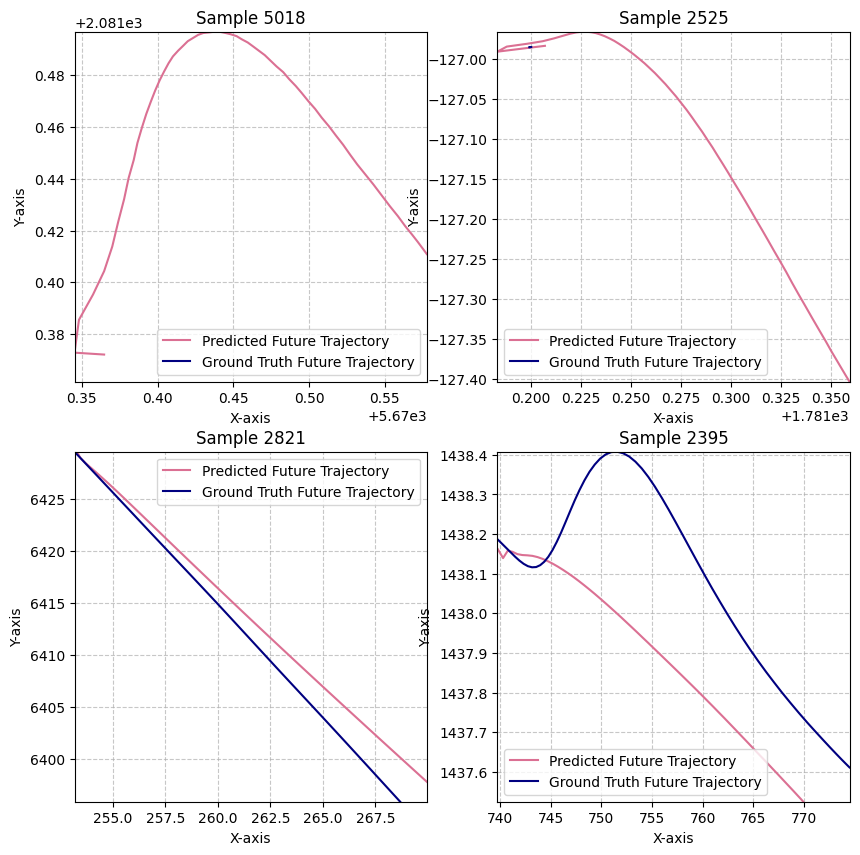

In [79]:
model = get_model()
if not isinstance(model, SceneContextModel):
    # LSTM can handle the timeseries data directly
    # TrajectoryDataset expects numpy arrays
    collate_func = lambda x: Batch.from_data_list(x)
    train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
else:
    train_x: np.ndarray = train_data[..., :50, :]
    train_y: np.ndarray = train_data[:, 0, 50:, :2]
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

visualize_predictions(model, train_dataset)